In [26]:
import tensorflow as tf
import json
import numpy as np
#from tensorflow.keras import datasets, layers, models
import tensorflow as tf
import keras
import json
from keras import layers, models
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split

## Load in Data

Get this data from unzipping the folder "LSTM_Inputs" in Google Drive!

In [142]:
img_size, img_size_1 = '11', '11'
size=img_size+'x'+img_size_1
start = datetime.datetime.now()
with open('processed_'+size+'/crashes_4d_24_hour.json', 'r') as f:
    array_4d_list = json.load(f)

# Convert the nested list back to a numpy array
array_4d_24_hour = np.array(array_4d_list)

with open('processed_'+size+'/crashes_4d_one_hour.json', 'r') as f:
    array_4d_list = json.load(f)
array_4d_1_hour = np.array(array_4d_list) 

with open('processed_'+size+'/'+size+'_traffic_1_hour.json', 'r') as f:
    traffic_1_hour_list = json.load(f)
traffic_1_hour = np.array(traffic_1_hour_list) 
traffic_1_hour_normalized = (traffic_1_hour - traffic_1_hour.min(axis=(1, 2), keepdims=True)) / (traffic_1_hour.max(axis=(1, 2), keepdims=True) - traffic_1_hour.min(axis=(1, 2), keepdims=True))

with open('1_hour_weather_data_1_hot.json', 'r') as f:
    traffic_1_hour_list = json.load(f)
weather_1_hour = np.array(traffic_1_hour_list) 

with open('1_hour_weather_data_1_hot_with_hour.json', 'r') as f:
    weather_1_hour_list_with_hour = json.load(f)
weather_1_hour_with_hour = np.array(weather_1_hour_list_with_hour) 

binary_output_1_hour = (array_4d_1_hour > 0).astype(int)
print("Finished Loading in:", datetime.datetime.now()-start)

Finished Loading in: 0:00:35.460337


In [146]:
# Split into training and testing sets with 0.8-0.2
Accident_train, Accident_test, Traffic_train, Traffic_test, Weather_train, Weather_test, Weather_Hr_train, Weather_Hr_test, Out_train, Out_test, Binary_Out_train, Binary_Out_test = train_test_split(array_4d_24_hour, traffic_1_hour_normalized, weather_1_hour, weather_1_hour_with_hour, array_4d_1_hour, binary_output_1_hour, test_size=0.2, random_state=42)

In [ ]:
# Save train-test splits using numpy
np.save('11x11/model_data/Accident_train.npy', Accident_train)
np.save('11x11/model_data/Accident_test.npy', Accident_test)
np.save('11x11/model_data/Traffic_train.npy', Traffic_train)
np.save('11x11/model_data/Traffic_test.npy', Traffic_test)
np.save('11x11/model_data/Weather_train.npy', Weather_train)
np.save('11x11/model_data/Weather_test.npy', Weather_test)
np.save('11x11/model_data/Weather_Hr_train.npy', Weather_Hr_train)
np.save('11x11/model_data/Weather_Hr_test.npy', Weather_Hr_test)
np.save('11x11/model_data/Out_train.npy', Out_train)
np.save('11x11/model_data/Out_test.npy', Out_test)
np.save('11x11/model_data/Binary_Out_train.npy', Binary_Out_train)
np.save('11x11/model_data/Binary_Out_test.npy', Binary_Out_test)

#To load back in as a numpy array
#Accident_train = np.load('Accident_train.npy')


## 1. Full Model - Regression

In [144]:
#Define inputs
input_past_accidents_shape = layers.Input(shape=(int(img_size), int(img_size), 24)) # Convolution
input_past_traffic_shape = layers.Input(shape=(int(img_size), int(img_size), 1)) # Convolution
input_past_weather_shape = layers.Input(shape=(23, )) #Not binary

#Convolution Layers For Accidents
accidents_layer_1 = layers.Conv2D(64, (3, 3), activation='relu')(input_past_accidents_shape)
accidents_layer_2 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(accidents_layer_1)

accidents_layer_3 = layers.Conv2D(30, (3, 3), activation='relu')(accidents_layer_2)
accidents_layer_4 = layers.MaxPooling2D((2, 2))(accidents_layer_3)
accidents_layer_5 = layers.Flatten()(accidents_layer_2)
accidents_layer_6 = layers.Dense(24, activation='relu')(accidents_layer_5)
accidents_layer_7 = layers.Reshape((24, 1))(accidents_layer_6)
accidents_layer_8 = layers.LSTM(64, return_sequences=False)(accidents_layer_7)
accidents_layer_9 = layers.Dense(16, activation='relu')(accidents_layer_8)

#Convolution Layers for Traffic
traffic_layer_1 = layers.Conv2D(30, (3, 3), activation='relu')(input_past_traffic_shape)
traffic_layer_2 = layers.MaxPooling2D(pool_size=(3, 1))(traffic_layer_1)
traffic_layer_3 = layers.Flatten()(traffic_layer_2)
traffic_layer_4 = layers.Dense(64, activation='relu')(traffic_layer_3)
traffic_layer_5 = layers.Dense(16, activation='relu')(traffic_layer_3)

#Fully Connected Layers of Weather
weather_layer_1 = layers.Dense(64, activation='relu')(input_past_weather_shape)
weather_layer_2 = layers.Dense(32, activation='relu')(weather_layer_1)
weather_layer_3 = layers.Dense(16, activation='relu')(weather_layer_2)

#Combine Layers
hadamard_product_layer = layers.Multiply()([accidents_layer_9, traffic_layer_5, weather_layer_3])
# Dense layer to produce a vector of length 11*11 (121) - ensure the shape matches
dense_layer_1 = layers.Dense(11 * 11, activation='linear')(hadamard_product_layer)

# Reshape output to (11, 11, 1) for final layer
output_layer = layers.Reshape((11, 11, 1))(dense_layer_1)

model = Model(inputs=[input_past_accidents_shape, input_past_traffic_shape, input_past_weather_shape], outputs=output_layer)
 
# Model summary
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_116     │ (None, 11, 11,    │          0 │ -                 │
│ (InputLayer)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_88 (Conv2D)  │ (None, 9, 9, 64)  │     13,888 │ input_layer_116[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_88    │ (None, 3, 9, 64)  │          0 │ conv2d_88[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_64          │ (None, 1728)      │          0 │ max_pooling2d_88… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_117     │ (None, 11, 11, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_203 (Dense)   │ (None, 24)        │     41,496 │ flatten_64[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_90 (Conv2D)  │ (None, 9, 9, 30)  │        300 │ input_layer_117[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_118     │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_49          │ (None, 24, 1)     │          0 │ dense_203[0][0]   │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_90    │ (None, 3, 9, 30)  │          0 │ conv2d_90[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_207 (Dense)   │ (None, 64)        │      1,536 │ input_layer_118[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_31 (LSTM)      │ (None, 64)        │     16,896 │ reshape_49[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_65          │ (None, 810)       │          0 │ max_pooling2d_90… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_208 (Dense)   │ (None, 32)        │      2,080 │ dense_207[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_204 (Dense)   │ (None, 16)        │      1,040 │ lstm_31[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_206 (Dense)   │ (None, 16)        │     12,976 │ flatten_65[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_209 (Dense)   │ (None, 16)        │        528 │ dense_208[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_27         │ (None, 16)        │          0 │ dense_204[0][0],  │
│ (Multiply)          │                   │            │ dense_206[0][0],  │
│                     │                   │            │ dense_209[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_210 (Dense)   │ (None, 121)       │      2,057 │ multiply_27[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_50          │ (None, 11, 11, 1) │          0 │ dense_210[0][0] 

 Total params: 92,797 (362.49 KB)

 Trainable params: 92,797 (362.49 KB)

 Non-trainable params: 0 (0.00 B)

In [147]:
## Split into training and testing sets with 0.8-0.2
history = model.fit([Accident_train, Traffic_train, Weather_Hr_train], Out_train, epochs=10, batch_size=32)

Epoch 1/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.1184 - mae: 0.1356
Epoch 2/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1073 - mae: 0.1363
Epoch 3/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1060 - mae: 0.1344
Epoch 4/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1078 - mae: 0.1354
Epoch 5/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1058 - mae: 0.1334
Epoch 6/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1057 - mae: 0.1333
Epoch 7/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1070 - mae: 0.1339
Epoch 8/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1051 - mae: 0.1323
Epoch 9/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1063 - mae: 0.1330
Epoch 10/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1047 - mae: 0.1318


In [167]:
model.save('11x11/models_/full_regression.keras')

#To load back in, just do:
#loaded_model = load_model('11x11/models_/full_binary.keras')
#loaded_model.predict(x_test)!

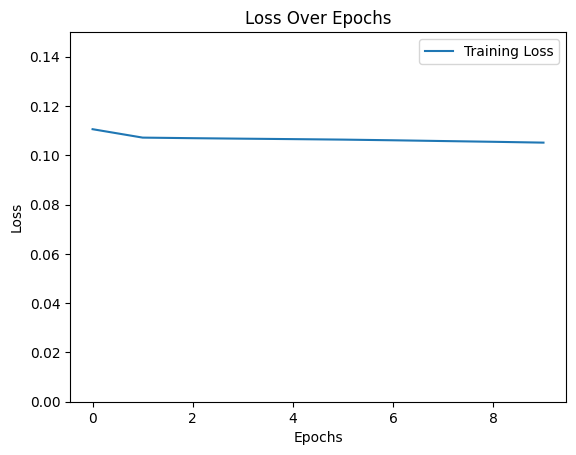

In [148]:
# Extract training and validation losses
train_loss = history.history['loss']
#val_loss = history.history['val_loss']

# Plot both
plt.plot(train_loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss', linestyle='--')
plt.ylim(0, 0.15)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

In [150]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([Accident_test, Traffic_test, Weather_Hr_test], Out_test)

# Print the MAE
print(f"Test MAE: {test_mae}")

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1087 - mae: 0.1379
Test MAE: 0.1372993290424347


In [ ]:
predictions_test = model.predict([Accident_test, Traffic_test, Weather_Hr_test])
predictions_train = model.predict([Accident_train, Traffic_train, Weather_Hr_train])

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
np.save('11x11/models_/model_regression_test_predictions_values.npy', predictions_test)
np.save('11x11/models_/model_regression_train_predictions_values.npy', predictions_train)

1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


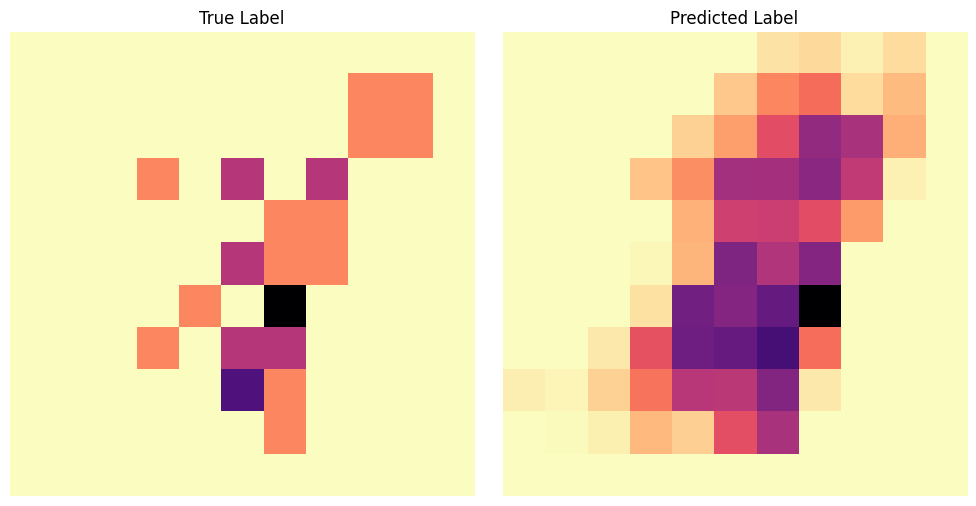

In [178]:
import matplotlib.pyplot as plt

# Plot the true label and predicted label side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot true label (Y_test[-1])
axes[0].imshow(Out_test[-50], cmap='magma_r')
axes[0].set_title("True Label")
axes[0].axis('off')  # Hide axis for better visualization

# Plot prediction (predictions[-1])
axes[1].imshow(predictions_test[-50], cmap='magma_r')
axes[1].set_title("Predicted Label")
axes[1].axis('off')  # Hide axis for better visualization

# Show the plot
plt.tight_layout()  # Adjust spacing
plt.show()


## 2. Full-Model Classification

In [155]:
#Define inputs
input_past_accidents_shape = layers.Input(shape=(int(img_size), int(img_size), 24)) # Convolution
input_past_traffic_shape = layers.Input(shape=(int(img_size), int(img_size), 1)) # Convolution
input_past_weather_shape = layers.Input(shape=(23, )) #Not binary

#Convolution Layers For Accidents
accidents_layer_1 = layers.Conv2D(64, (3, 3), activation='relu')(input_past_accidents_shape)
accidents_layer_2 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(accidents_layer_1)

accidents_layer_3 = layers.Conv2D(30, (3, 3), activation='relu')(accidents_layer_2)
accidents_layer_4 = layers.MaxPooling2D((2, 2))(accidents_layer_3)
accidents_layer_5 = layers.Flatten()(accidents_layer_2)
accidents_layer_6 = layers.Dense(24, activation='relu')(accidents_layer_5)
accidents_layer_7 = layers.Reshape((24, 1))(accidents_layer_6)
accidents_layer_8 = layers.LSTM(64, return_sequences=False)(accidents_layer_7)
accidents_layer_9 = layers.Dense(16, activation='relu')(accidents_layer_8)

#Convolution Layers for Traffic
traffic_layer_1 = layers.Conv2D(30, (3, 3), activation='relu')(input_past_traffic_shape)
traffic_layer_2 = layers.MaxPooling2D(pool_size=(3, 1))(traffic_layer_1)
traffic_layer_3 = layers.Flatten()(traffic_layer_2)
traffic_layer_4 = layers.Dense(64, activation='relu')(traffic_layer_3)
traffic_layer_5 = layers.Dense(16, activation='relu')(traffic_layer_3)

#Fully Connected Layers of Weather
weather_layer_1 = layers.Dense(64, activation='relu')(input_past_weather_shape)
weather_layer_2 = layers.Dense(32, activation='relu')(weather_layer_1)
weather_layer_3 = layers.Dense(16, activation='relu')(weather_layer_2)

#Combine Layers
hadamard_product_layer = layers.Multiply()([accidents_layer_9, traffic_layer_5, weather_layer_3])
# Dense layer to produce a vector of length 11*11 (121) - ensure the shape matches
dense_layer_1 = layers.Dense(11 * 11, activation='sigmoid')(hadamard_product_layer)

# Reshape output to (11, 11, 1) for final layer
output_layer = layers.Reshape((11, 11, 1))(dense_layer_1)

model_binary = Model(inputs=[input_past_accidents_shape, input_past_traffic_shape, input_past_weather_shape], outputs=output_layer)
 
# Model summary
model_binary.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summarize the model
model_binary.summary()


Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_121     │ (None, 11, 11,    │          0 │ -                 │
│ (InputLayer)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_91 (Conv2D)  │ (None, 9, 9, 64)  │     13,888 │ input_layer_121[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_91    │ (None, 3, 9, 64)  │          0 │ conv2d_91[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_66          │ (None, 1728)      │          0 │ max_pooling2d_91… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_122     │ (None, 11, 11, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_211 (Dense)   │ (None, 24)        │     41,496 │ flatten_66[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_93 (Conv2D)  │ (None, 9, 9, 30)  │        300 │ input_layer_122[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_123     │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_51          │ (None, 24, 1)     │          0 │ dense_211[0][0]   │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_93    │ (None, 3, 9, 30)  │          0 │ conv2d_93[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_215 (Dense)   │ (None, 64)        │      1,536 │ input_layer_123[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_32 (LSTM)      │ (None, 64)        │     16,896 │ reshape_51[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_67          │ (None, 810)       │          0 │ max_pooling2d_93… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_216 (Dense)   │ (None, 32)        │      2,080 │ dense_215[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_212 (Dense)   │ (None, 16)        │      1,040 │ lstm_32[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_214 (Dense)   │ (None, 16)        │     12,976 │ flatten_67[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_217 (Dense)   │ (None, 16)        │        528 │ dense_216[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_28         │ (None, 16)        │          0 │ dense_212[0][0],  │
│ (Multiply)          │                   │            │ dense_214[0][0],  │
│                     │                   │            │ dense_217[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_218 (Dense)   │ (None, 121)       │      2,057 │ multiply_28[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_52          │ (None, 11, 11, 1) │          0 │ dense_218[0][0] 

 Total params: 92,797 (362.49 KB)

 Trainable params: 92,797 (362.49 KB)

 Non-trainable params: 0 (0.00 B)

In [156]:
## Split into training and testing sets with 0.8-0.2
history_binary = model_binary.fit([Accident_train, Traffic_train, Weather_Hr_train], Binary_Out_train, epochs=10, batch_size=32)

Epoch 1/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8818 - loss: 0.2955
Epoch 2/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9229 - loss: 0.1766
Epoch 3/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9234 - loss: 0.1750
Epoch 4/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9241 - loss: 0.1735
Epoch 5/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9241 - loss: 0.1734
Epoch 6/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9244 - loss: 0.1728
Epoch 7/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9240 - loss: 0.1732
Epoch 8/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9243 - loss: 0.1727
Epoch 9/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9243 - loss: 0.1725
Epoch 10/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9243 - loss: 0.1727


In [166]:
model_binary.save('11x11/models_/full_binary.keras')

#To load back in, just do:
#loaded_model = load_model('11x11/models_/full_binary.keras')
#loaded_model.predict(x_test)!

In [157]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_binary.evaluate([Accident_test, Traffic_test, Weather_Hr_test], Binary_Out_test)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9234 - loss: 0.1740
Test Loss: 0.17341800034046173
Test Accuracy: 0.9237574338912964


In [180]:
predictions_model_binary_test = model_binary.predict([Accident_test, Traffic_test, Weather_Hr_test])
# Threshold at 0.5 to convert output to binary (0 or 1)
binary_predictions_test = (predictions_model_binary_test > 0.5).astype(int)

predictions_model_binary_train = model_binary.predict([Accident_train, Traffic_train, Weather_Hr_train])
# Threshold at 0.5 to convert output to binary (0 or 1)
binary_predictions_train= (predictions_model_binary_train > 0.5).astype(int)

270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [181]:
np.save('11x11/models_/model_binary_test_predictions_values.npy', binary_predictions_test)
np.save('11x11/models_/model_binary_train_predictions_values.npy', binary_predictions_train)
np.save('11x11/models_/model_binary_test_predictions_probs.npy', predictions_model_binary_test)
np.save('11x11/models_/model_binary_train_predictions_probs.npy', predictions_model_binary_train)

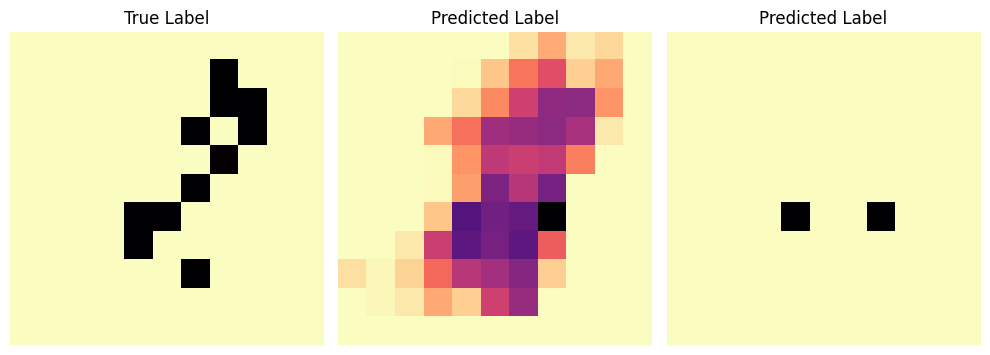

In [159]:
import matplotlib.pyplot as plt

# Plot the true label and predicted label side by side
fig, axes = plt.subplots(1, 3, figsize=(10, 8))  # 1 row, 2 columns
i=-5000

# Plot true label (Y_test[-1])
axes[0].imshow(Binary_Out_test[i], cmap='magma_r')
axes[0].set_title("True Label")
axes[0].axis('off')  # Hide axis for better visualization

# Plot prediction (predictions[-1])
axes[1].imshow(predictions_model_binary[i], cmap='magma_r')
axes[1].set_title("Predicted Label")
axes[1].axis('off')  # Hide axis for better visualization

# Plot prediction (predictions[-1])
axes[2].imshow(binary_predictions[i], cmap='magma_r')
axes[2].set_title("Predicted Label")
axes[2].axis('off')  # Hide axis for better visualization


# Show the plot
plt.tight_layout()  # Adjust spacing
plt.show()


### Plot ROC Curve On Test Data

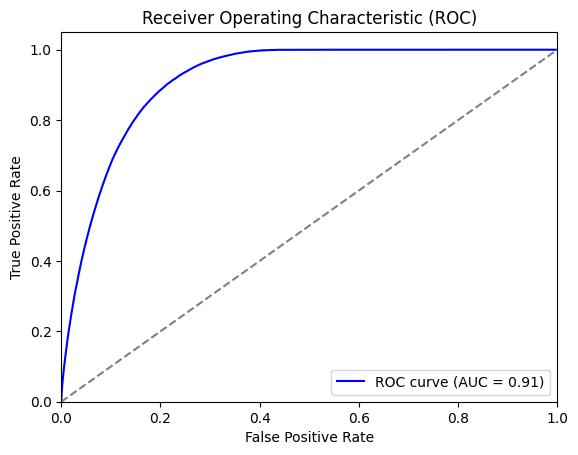

In [160]:
#Flatten Data for Graph
Binary_Out_test_flattened = Binary_Out_test.reshape(-1)
binary_predictions_flattened = predictions_model_binary.reshape(-1)

from sklearn.metrics import auc, roc_curve
fpr, tpr, thresholds = roc_curve(Binary_Out_test_flattened, binary_predictions_flattened)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random model)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## 3. Regression Model (No Spatial)

/Users/ch/miniforge3/envs/finaljobsllm/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_83 (Conv2D)              │ (None, 9, 9, 30)       │         6,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 2, 2, 64)       │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_61 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_45 (Reshape)            │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 121)            │         7,865 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_46 (Reshape)            │ (None, 11, 11, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,175 (196.00 KB)

 Trainable params: 50,175 (196.00 KB)

 Non-trainable params: 0 (0.00 B)